<a href="https://colab.research.google.com/github/ameyas1/Sentiment_Analysis/blob/master/bert_sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Download Dataset From Kaggle**

In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [2]:
!kaggle datasets download -d kazanova/sentiment140

 69% 56.0M/80.9M [00:00<00:00, 137MB/s]
100% 80.9M/80.9M [00:00<00:00, 205MB/s]


In [3]:
!unzip /content/sentiment140.zip

Archive:  /content/sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [4]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 5.9MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.4-cp36-none-any.whl size=30114 sha256=f4120568d0048fcfad8cf93ebecc09cca9330f7128bf30203172963ff61793be
  Stored in directory: /root/.cache/pip/wheels/cf/3f/4d/79d7735015a5f523648df90d871ce8e89a7df8185f7703eeab
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=dfa93ea16dacf7ea1190b94609542cd62a8f6319698927495bdfdbc5876e8af4
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19473 sha256=dc8b5ad053d8cd2f3feaa1b624a78d25b7e4f8aa7f2a15b9433026325c3e2345
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [5]:
import numpy as np 
import pandas as pd
import bert
from tensorflow.keras.models import Model       # Keras is the new high level API for TensorFlow
import math
import tensorflow as tf
import tensorflow_hub as hub


In [6]:
FullTokenizer = bert.bert_tokenization.FullTokenizer

In [7]:
max_seq_length = 128  # Your choice here.
# input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
#                                        name="input_word_ids")
# input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
#                                    name="input_mask")
# segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
#                                     name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)
# pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [8]:
# model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_output, sequence_output])

In [9]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

**Preprocess**

In [10]:
df=pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None)

In [11]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [12]:
df.shape

(1600000, 6)

In [13]:
df=df[[0,5]]
df.columns = ['sentiment','text']

In [14]:
df = df.sample(frac=0.04, random_state=5)

In [15]:
df.shape

(64000, 2)

In [16]:
df.head(10)

,sentiment,text
1425895,4,Just back from an excellent concert from the G...
1153784,4,@gfalcone601 Aww Gi.don't worry.we'll vote for...
1424137,4,watching #fatafeat
82854,0,@fallenstar_ LOL don't do that please!!!!
1271893,4,@ShaneDaddict Its ok
1375687,4,Kaitlyn i feel your pain. Ive been home to and...
65177,0,@mickayyyla dont eww my haupia its great! HAH...
1353647,4,@rfeastsidedave my first twitter friend aweso...
738451,0,Just brought a turtle ...pretty sure it hates ...
1284503,4,@dave_holmes thanks for you help


In [17]:
import re


def process_text(text):
    text = text.replace('#', 'hashtag ')
    text = re.sub(r"https?://\S+", '', text)
    text = re.sub(r"^@\S+|\s@\S+",'', text)

    
    return text.strip().rstrip()

In [18]:
df.text = df.text.apply(process_text)

In [19]:
df.head()

,sentiment,text
1425895,4,Just back from an excellent concert from the G...
1153784,4,Aww Gi.don't worry.we'll vote for you non-stop...
1424137,4,watching hashtag fatafeat
82854,0,LOL don't do that please!!!!
1271893,4,Its ok


In [20]:
sentiments = df.sentiment.values
sentences = df.text.values

In [21]:
sentiments[sentiments==4]=1

In [22]:
sentiments[-1],sentences[-1]

(1, 'Its HOT!')

In [23]:
sentiments[100],sentences[100]

(0, 'I tripped going down my stairs And my mom started laughing')

In [24]:
def encode_sentence(s, tokenizer):
    tokens = list(tokenizer.tokenize(s))
    # tokens = ["[CLS]"] + tokens + ["[SEP]"]

    return tokenizer.convert_tokens_to_ids(tokens)

In [25]:
def bert_encode(sentences, tokenizer):
    sentence = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(sentences)])
    
    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence.shape[0]
    sep = [tokenizer.convert_tokens_to_ids(['[SEP]'])]*sentence.shape[0]
    input_word_ids = tf.concat([cls, sentence, sep], axis=-1)
    
    max_len = tf.reduce_max([s.shape[0] for s in input_word_ids]).numpy()
    
    print(max_len)
    
    input_mask = tf.ones_like(input_word_ids).to_tensor()
    
    input_segment = tf.zeros_like(input_word_ids).to_tensor()
        
    input_word_ids = tf.keras.preprocessing.sequence.pad_sequences(
    input_word_ids.to_list(), maxlen=max_len, dtype='int32', padding='post',value=0)
    
    print('input ids done')
    
    input_mask = tf.keras.preprocessing.sequence.pad_sequences(
    input_mask, maxlen=max_len, dtype='int32', padding='post',value=0)
    
    print('input masks done')
    
    input_segment = tf.keras.preprocessing.sequence.pad_sequences(
    input_segment, maxlen=max_len, dtype='int32', padding='post',value=0)

    print('input segments done')
    
    inputs = {
      'input_word_ids': input_word_ids,
      'input_mask': input_mask,
      'segment_ids': input_segment}

    return inputs

In [26]:
inputs = bert_encode(sentences,tokenizer)

152
input ids done
input masks done
input segments done


In [27]:
senti = {'sentiments': sentiments}

In [33]:
import pickle

with open('inp.p', 'wb') as fp:
    pickle.dump(inputs, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
with open('sent.p', 'wb') as fp1:
    pickle.dump(senti, fp1, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
!mv /content/inp.p '/content/drive/My Drive/cp'
!mv /content/sent.p '/content/drive/My Drive/cp'

In [7]:
import pickle

with open('/content/drive/My Drive/cp/inp.p', 'rb') as p:
    inputs = pickle.load(p)

with open('/content/drive/My Drive/cp/sent.p', 'rb') as p1:
    sentiment = pickle.load(p1)

In [8]:
sentiments = sentiment['sentiments']

In [28]:
def test(tokenizer, inputs, sentiments, ind):
  print('ids')
  print(inputs['input_word_ids'][ind])
  print('mask')
  print(inputs['input_mask'][ind])
  print('segment')
  print(inputs['segment_ids'][ind])
  print('words')
  for t in inputs['input_word_ids'][ind]:
    if t!=0:
      print(tokenizer.convert_ids_to_tokens([t]))
  print('sentiment')
  print(sentiments[ind])



In [29]:
test(tokenizer,inputs, sentiments, 60)

ids
[ 101 2851 1012 3246 2017 2024 2383 1037 3835 2051  102    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
mask
[1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [9]:
sentiments[:10]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1])

In [30]:
total = len(sentiments)

In [48]:
batch_size= 32
train = tf.data.Dataset.from_tensor_slices((inputs,sentiments))
# test = test.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# test = test.batch(batch_size)

In [49]:
train = train.cache().shuffle(total)
train = train.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [62]:
max_seq_length = 152  # Your choice here.
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [63]:
expand_pool = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,1))(pooled_output)
pool_lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(160,return_sequences=True))(expand_pool)
pool_lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(160))(pool_lstm1)
# model.add(tf.keras.layers.Dense(160, activation='relu'))

In [64]:
seq_lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(160,return_sequences=True))(sequence_output)
seq_lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(160))(seq_lstm1)

In [65]:
concat = tf.keras.layers.concatenate([seq_lstm2,pool_lstm2])

In [66]:
dense1 = tf.keras.layers.Dense(320, activation='relu')(concat)
do1 = tf.keras.layers.Dropout(0.2)(dense1)
dense2 = tf.keras.layers.Dense(160, activation='relu')(do1)
do2 = tf.keras.layers.Dropout(0.2)(dense2)
pred = tf.keras.layers.Dense(2, activation='softmax')(do2)

model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pred)

In [56]:
# last_layer = model.get_layer('keras_layer_1')
# print('keras layer output shape: ', last_layer.output_shape)

In [67]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 152)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 152)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 152)]        0                                            
__________________________________________________________________________________________________
keras_layer_4 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

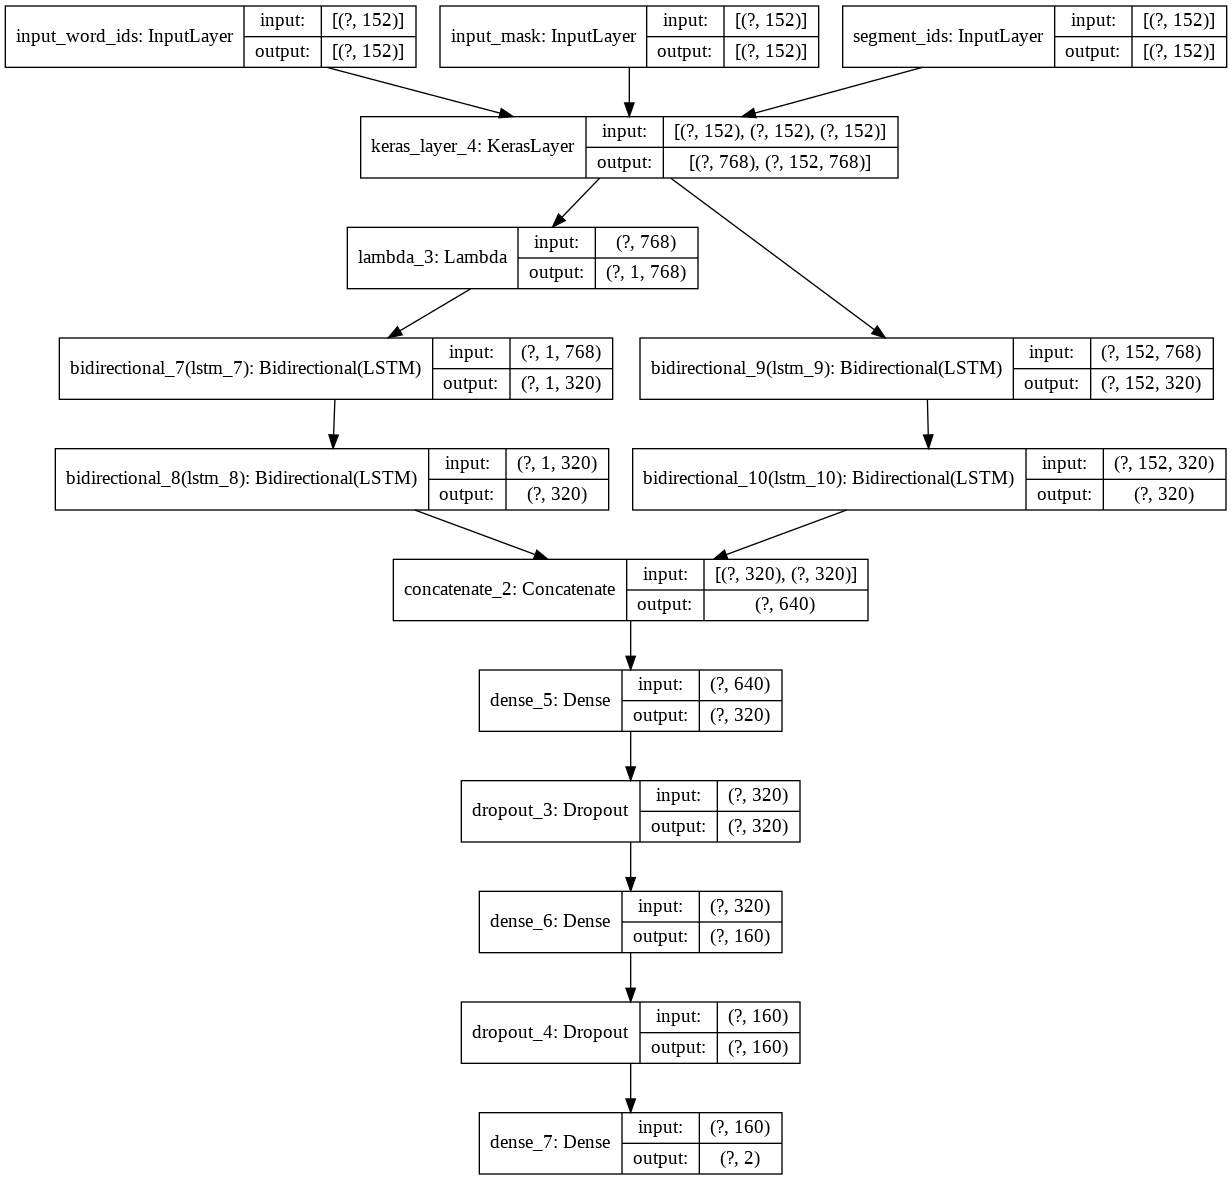

In [68]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [69]:
model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [70]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath="cp/sentiment_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

!mkdir cp


callbacks_list = [checkpoint]

mkdir: cannot create directory ‘cp’: File exists


In [94]:
history = model.fit(train, epochs=5, callbacks=callbacks_list)

Epoch 1/5
2000/2000 [==============================] - ETA: 0s - loss: 0.2335 - accuracy: 0.9015
Epoch 00001: loss improved from 0.29244 to 0.23349, saving model to cp/sentiment_model.hdf5
2000/2000 [==============================] - 832s 416ms/step - loss: 0.2335 - accuracy: 0.9015
Epoch 2/5
2000/2000 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.9279
Epoch 00002: loss improved from 0.23349 to 0.17692, saving model to cp/sentiment_model.hdf5
2000/2000 [==============================] - 832s 416ms/step - loss: 0.1769 - accuracy: 0.9279
Epoch 3/5
2000/2000 [==============================] - ETA: 0s - loss: 0.1326 - accuracy: 0.9472
Epoch 00003: loss improved from 0.17692 to 0.13264, saving model to cp/sentiment_model.hdf5
2000/2000 [==============================] - 831s 416ms/step - loss: 0.1326 - accuracy: 0.9472
Epoch 4/5
2000/2000 [==============================] - ETA: 0s - loss: 0.1005 - accuracy: 0.9604
Epoch 00004: loss improved from 0.13264 to 0.10047,

<Figure size 432x288 with 0 Axes>

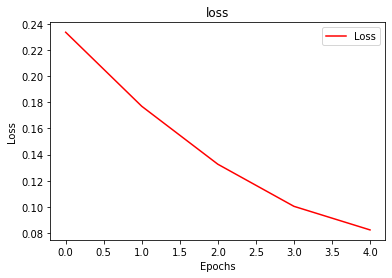

<Figure size 432x288 with 0 Axes>

In [95]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']


epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training  loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
# plt.plot(epochs, v_loss, 'b')
plt.title('loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [96]:
model.load_weights('/content/cp/sentiment_model.hdf5')

In [97]:
def predict_sentiment(text, tokenizer, max_len):
  
  processed_text = process_text(text)
  tokens = list(tokenizer.tokenize(processed_text))
  tokens = ["[CLS]"] + tokens + ["[SEP]"]

  print(tokens)
  encoded = tokenizer.convert_tokens_to_ids(tokens)

  encoded = tf.expand_dims(encoded, axis=0)
  
  input_mask = tf.ones_like(encoded)
    
  input_segment = tf.zeros_like(encoded)

  input_word_ids = tf.keras.preprocessing.sequence.pad_sequences(
  encoded, maxlen=max_len, dtype='int32', padding='post',value=0)

  input_mask = tf.keras.preprocessing.sequence.pad_sequences(
  input_mask, maxlen=max_len, dtype='int32', padding='post',value=0)
    
    
  input_segment = tf.keras.preprocessing.sequence.pad_sequences(
  input_segment, maxlen=max_len, dtype='int32', padding='post',value=0)

  inputs = {'input_word_ids': input_word_ids, 'input_mask': input_mask, 'segment_ids': input_segment}

  score = model.predict(inputs)[0]

  return {"negative": float(score[0]), "postive": float(score[1])} 










In [104]:
predict_sentiment("@breatheintotheshadows was liked by everyone but it was okay", tokenizer, max_len=152)

['[CLS]', 'was', 'liked', 'by', 'everyone', 'but', 'it', 'was', 'okay', '[SEP]']


{'negative': 0.9229295253753662, 'postive': 0.07707047462463379}